# Xception

In this notebook we will be implementing a modified version of [paper], a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). 

ImageNet dataset consist on a set of images (the authors used 1.28 million training images, 50k validation images and 100k test images) of size (224x224) belonging to 1000 different classes. However, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consist on a different set of images (45k training images, 5k validation images and 10k testing images) distributed into just 10 different classes. The classes are: <font color = red>airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck</font>. 

<br>
<div style="text-align: center">
    <img src="./../assets/cifar10.png" width="70%">
</div>
<br>

## Data Processing

As always, we'll import the modules we need. A new import is the `_LRScheduler` which we will use to implement our learning rate finder.

[paper]: https://arxiv.org/abs/1610.02357

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from collections import namedtuple

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, copy, math, random, shutil, time

We set the random seed so all of our experiments can be reproduced.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We calculate the mean and standard deviation of our data so we can normalize it.

Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently. 

To do this we pass a tuple containing the axes we want to take the means and standard deviations over to the `mean` and `std` functions and we receive a list of means and standard deviations for each of the three color channels.

In [3]:
ROOT = './../data'

# specify the names of the classes
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 
                5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

train_data = datasets.CIFAR10(root=ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis=(0, 1, 2)) / 255
stds = train_data.data.std(axis=(0, 1, 2)) / 255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Next up is defining the transforms for data augmentation. 

The images in the CIFAR10 dataset are significantly more complex than the MNIST dataset. They are larger, have three times the amount of pixels and are more cluttered. This makes them harder to learn and consequently means we should use less augmentation.

A new transform we use is `RandomHorizontalFlip`. This, with a probability of `0.5` as specified, flips the image horizontally. So an image of a horse facing to the right will be flipped so it will face to the left. We couldn't do this in the MNIST dataset as we are not expecting our test set to contain any flipped digits, however natural images, such as those in the CIFAR10 dataset, can potentially be flipped as they still make visual sense.

As our `means` and `stds` are now already in lists we do not need to enclose them in lists as we did for the single channel images in the MNIST dataset.

In [4]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

Next, as standard, we'll load the dataset with our transforms...

In [5]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


...create a validation set from our training set...

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

...and ensure our validation set uses the test transforms.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We print out the number of examples in each set of data to ensure everything has gone OK so far. The total num of CIFAR10 is 60000.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of all examples: {len(train_data) + len(valid_data) + len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000
Number of all examples: 60000


We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

The final bit of the data processing is creating the iterators.

We use a much larger batch size here than in previous models. Generally, when using a GPU, a larger batch size means our model trains faster. Our model has significantly more parameters and the images it is training on are much larger, than the previous notebook, so will generally take longer.

In [10]:
BATCH_SIZE = 3072

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the Model

Next up, we'll be defining our model. As mentioned previously, we'll be using Xception models. Let's look at the ResNet configuration table again:

[Reference](https://wikidocs.net/165431)

Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. It was developed by Google researchers. Google presented an interpretation of Inception modules in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution). In this light, a depthwise separable convolution can be understood as an Inception module with a maximally large number of towers. This observation leads them to propose a novel deep convolutional neural network architecture inspired by Inception, where Inception modules have been replaced with depthwise separable convolutions.

## What does it look like?
---

The data first goes through the entry flow, then through the middle flow which is repeated eight times, and finally through the exit flow. Note that all Convolution and SeparableConvolution layers are followed by batch normalization.

<div style="text-align:center">
    <img src="./assets/Xception.png">
</div>

As in the figure above, **SeparableConv** is the modified depthwise separable convolution. We can see that SeparableConvs are treated as Inception Modules and placed throughout the whole deep learning architecture.

And there are residual (or shortcut/skip) connections, originally proposed by ResNet, placed for all flows.

Xception architecture has overperformed VGG-16, ResNet and Inception V3 in most classical classification challenges.

## How does XCeption work?
---

XCeption is an efficient architecture that relies on two main points :

- Depthwise Separable Convolution
- Shortcuts between Convolution blocks as in ResNet

## Depthwise Separable Convolution
---

Depthwise Separable Convolutions are alternatives to classical convolutions that are supposed to be much more efficient in terms of computation time.


## Original Depthwise Separable Convolution
---

<div style="text-align:center">
    <img src="./assets/Original_Depthwise_Separable_Convolution.png">
</div>
<div style="text-align:center">Original Depthwise Separable Convolution</div>
<br>

The original depthwise separable convolution is the depthwise convolution followed by a pointwise convolution.

- Depthwise convolution is the channel-wise nxn spatial convolution. Suppose in the figure above, we have 5 channels, then we will have 5 nxn spatial convolution.
- Pointwise convolution actually is the 1x1 convolution to change the dimension.

Compared with conventional convolution, we do not need to perform convolution across all channels. That means the number of connections are fewer and the model is lighter.

## Modified Depthwise Separable Convolution in Xception
---

<div style="text-align:center">
    <img src="./assets/Modified_Depthwise_Separable_Convolution_in_Xception.png">
</div>
<div style="text-align:center">The Modified Depthwise Separable Convolution used as an Inception Module in Xception, so called “extreme” version of Inception module (n=3 here)</div>
<br>

The modified depthwise separable convolution is the pointwise convolution followed by a depthwise convolution. This modification is motivated by the inception module in Inception-v3 that 1X1 convolution is done first before any nxn spatial convolutions. Thus, it is a bit different from the original one. (n=3 here since 3x3 spatial convolutions are used in Inception-v3.)

Two minor differences:

- The order of operations: As mentioned, the original depthwise separable convolutions as usually implemented (e.g. in TensorFlow) perform first channel-wise spatial convolution and then perform 1X1 convolution whereas the modified depthwise separable convolution perform 1X1 convolution first then channel-wise spatial convolution. This is claimed to be unimportant because when it is used in stacked setting, there are only small differences appeared at the beginning and at the end of all the chained inception modules.

- The Presence/Absence of Non-Linearity: In the original Inception Module, there is non-linearity after first operation. In Xception, the modified depthwise separable convolution, there is NO intermediate ReLU non-linearity.

In [11]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        h = x.view(x.size(0), -1)
        x = self.fc(h)

        return (x, h)


def xception(pretrained=False,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model

We'll create an instance of our model with the desired amount of classes.

In [12]:
OUTPUT_DIM = 10

model = xception(num_classes=OUTPUT_DIM)
print(model)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

Then we'll see how many trainable parameters our model has. 

Our LeNet architecture had ~44k, but here we have 6.2M parameters - and GooLeNet is a relatively small model for computer vision.

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,827,442 trainable parameters


## Training the Model

Next up is the learning rate finder. The code here is taken from a stripped down and slightly modified version of the excellent [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 

**Note**: the learning rate finder is more of an art than a science. It is not going to find an exact learning rate to 10 decimal places which will always give us 100% accuracy - but it is usually going to be better than just picking a learning rate out of thin air.  

The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate. 

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated. 

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.

In [14]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):
            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):
        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [15]:
print( torch.cuda.is_available() )

True


In [16]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test` with the training iterator, the maximum learning rate and the number of iterations we want to use. 

In [17]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we can plot the learning rate against the loss. 

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [18]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before reaching a minimum and starting to increase. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

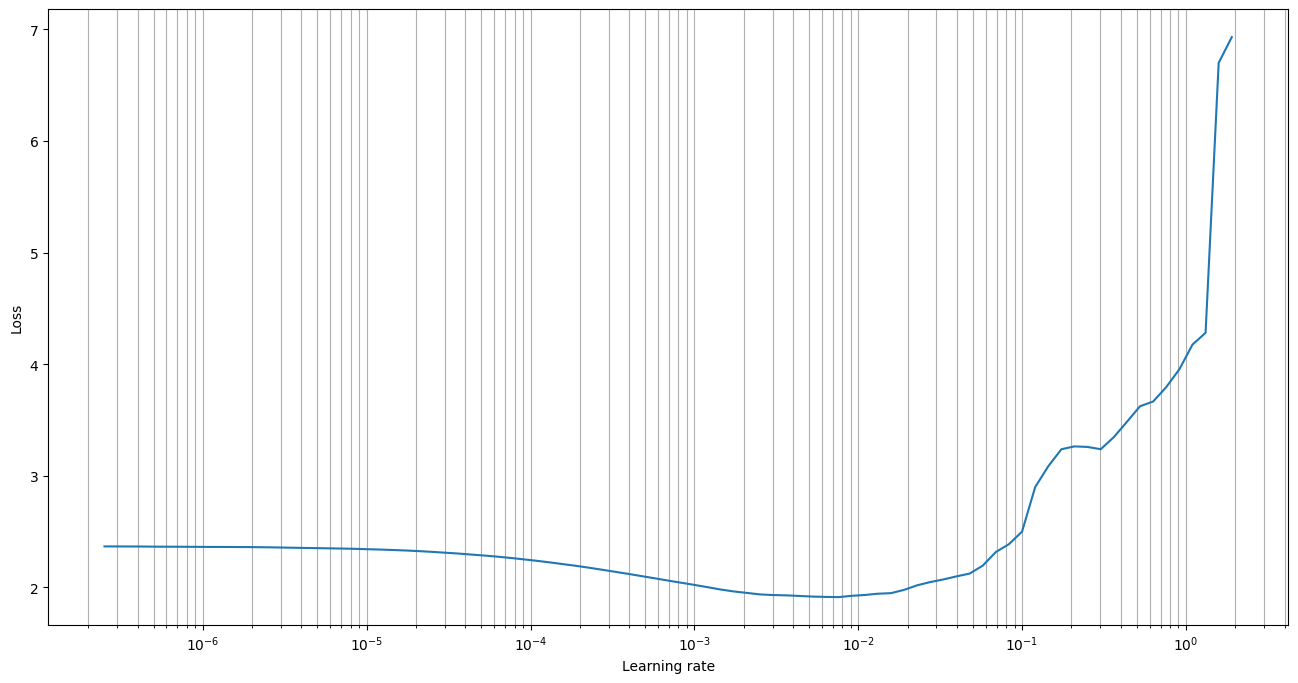

In [19]:
plot_lr_finder(lrs, losses)

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [20]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)

The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [21]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [22]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    top3_train_accuracy = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        ps = torch.exp(y_pred)
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = y.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    return (epoch_loss/len(iterator)), (epoch_acc/len(iterator)), (top3_train_accuracy/len(iterator))

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [23]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    top3_test_accuracy = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            ps = torch.exp(y_pred)
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = y.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
    return (epoch_loss/len(iterator)), (epoch_acc/len(iterator)), (top3_test_accuracy/len(iterator))

Next, we define a function to tell us how long an epoch takes.

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

Then, finally, we train our model.

We get a best validation loss of ~88% accuracy.

In [25]:
EPOCHS = 50
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 
                                      'Train loss', 'Train accuracy', 'Train top-3 accuracy', 
                                      'Test loss', 'Test accuracy', 'Test top-3 accuracy'])

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    train_loss, train_acc, top3_train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, top3_valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'xception-cifar10-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    time_elapsed = end_time - start_time

    df = pd.DataFrame.from_dict(
                [ {'Epoch': epoch, 'Time per epoch':time_elapsed, 
                  'Avg time per step': time_elapsed/len(train_iterator), 
                  'Train loss' : train_loss, 
                  'Train accuracy': train_acc, 
                  'Train top-3 accuracy':top3_train_acc,
                  'Test loss' : valid_loss, 
                  'Test accuracy': valid_acc, 
                  'Test top-3 accuracy':top3_valid_acc} ] )
    train_stats = pd.concat([ train_stats, df], ignore_index=True)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Top3 train Acc: {train_acc*100:.2f}%')  
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Top3 valid Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.790 | Train Acc: 35.32% | Top3 train Acc: 35.32%
	 Val. Loss: 2.302 |  Val. Acc: 11.21% | Top3 valid Acc: 11.21%


Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.362 | Train Acc: 50.32% | Top3 train Acc: 50.32%
	 Val. Loss: 2.302 |  Val. Acc: 11.21% | Top3 valid Acc: 11.21%


Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.217 | Train Acc: 55.84% | Top3 train Acc: 55.84%
	 Val. Loss: 2.293 |  Val. Acc: 11.22% | Top3 valid Acc: 11.22%


Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.114 | Train Acc: 60.00% | Top3 train Acc: 60.00%
	 Val. Loss: 2.040 |  Val. Acc: 29.91% | Top3 valid Acc: 29.91%


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.041 | Train Acc: 62.82% | Top3 train Acc: 62.82%
	 Val. Loss: 1.221 |  Val. Acc: 60.84% | Top3 valid Acc: 60.84%


Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.981 | Train Acc: 64.95% | Top3 train Acc: 64.95%
	 Val. Loss: 1.065 |  Val. Acc: 62.35% | Top3 valid Acc: 62.35%


Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.923 | Train Acc: 66.77% | Top3 train Acc: 66.77%
	 Val. Loss: 1.044 |  Val. Acc: 63.88% | Top3 valid Acc: 63.88%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.879 | Train Acc: 68.72% | Top3 train Acc: 68.72%
	 Val. Loss: 0.940 |  Val. Acc: 67.29% | Top3 valid Acc: 67.29%


Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.834 | Train Acc: 70.34% | Top3 train Acc: 70.34%
	 Val. Loss: 0.916 |  Val. Acc: 68.33% | Top3 valid Acc: 68.33%


Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.799 | Train Acc: 71.59% | Top3 train Acc: 71.59%
	 Val. Loss: 0.890 |  Val. Acc: 69.13% | Top3 valid Acc: 69.13%


Epoch: 11 | Epoch Time: 0m 22s
	Train Loss: 0.753 | Train Acc: 73.34% | Top3 train Acc: 73.34%
	 Val. Loss: 0.871 |  Val. Acc: 70.05% | Top3 valid Acc: 70.05%


Epoch: 12 | Epoch Time: 0m 22s
	Train Loss: 0.713 | Train Acc: 74.49% | Top3 train Acc: 74.49%
	 Val. Loss: 0.868 |  Val. Acc: 69.87% | Top3 valid Acc: 69.87%


Epoch: 13 | Epoch Time: 0m 22s
	Train Loss: 0.688 | Train Acc: 75.58% | Top3 train Acc: 75.58%
	 Val. Loss: 0.841 |  Val. Acc: 71.72% | Top3 valid Acc: 71.72%


Epoch: 14 | Epoch Time: 0m 21s
	Train Loss: 0.664 | Train Acc: 76.47% | Top3 train Acc: 76.47%
	 Val. Loss: 0.853 |  Val. Acc: 71.79% | Top3 valid Acc: 71.79%


Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 0.632 | Train Acc: 77.55% | Top3 train Acc: 77.55%
	 Val. Loss: 0.870 |  Val. Acc: 70.96% | Top3 valid Acc: 70.96%


Epoch: 16 | Epoch Time: 0m 22s
	Train Loss: 0.604 | Train Acc: 78.69% | Top3 train Acc: 78.69%
	 Val. Loss: 0.852 |  Val. Acc: 72.66% | Top3 valid Acc: 72.66%


Epoch: 17 | Epoch Time: 0m 22s
	Train Loss: 0.581 | Train Acc: 79.39% | Top3 train Acc: 79.39%
	 Val. Loss: 0.837 |  Val. Acc: 72.01% | Top3 valid Acc: 72.01%


Epoch: 18 | Epoch Time: 0m 21s
	Train Loss: 0.567 | Train Acc: 79.65% | Top3 train Acc: 79.65%
	 Val. Loss: 0.889 |  Val. Acc: 70.67% | Top3 valid Acc: 70.67%


Epoch: 19 | Epoch Time: 0m 21s
	Train Loss: 0.545 | Train Acc: 80.69% | Top3 train Acc: 80.69%
	 Val. Loss: 0.849 |  Val. Acc: 72.08% | Top3 valid Acc: 72.08%


Epoch: 20 | Epoch Time: 0m 22s
	Train Loss: 0.527 | Train Acc: 81.12% | Top3 train Acc: 81.12%
	 Val. Loss: 0.828 |  Val. Acc: 73.19% | Top3 valid Acc: 73.19%


Epoch: 21 | Epoch Time: 0m 22s
	Train Loss: 0.505 | Train Acc: 82.02% | Top3 train Acc: 82.02%
	 Val. Loss: 0.828 |  Val. Acc: 73.60% | Top3 valid Acc: 73.60%


Epoch: 22 | Epoch Time: 0m 22s
	Train Loss: 0.472 | Train Acc: 83.24% | Top3 train Acc: 83.24%
	 Val. Loss: 0.814 |  Val. Acc: 72.88% | Top3 valid Acc: 72.88%


Epoch: 23 | Epoch Time: 0m 22s
	Train Loss: 0.452 | Train Acc: 83.71% | Top3 train Acc: 83.71%
	 Val. Loss: 0.809 |  Val. Acc: 75.13% | Top3 valid Acc: 75.13%


Epoch: 24 | Epoch Time: 0m 21s
	Train Loss: 0.423 | Train Acc: 84.89% | Top3 train Acc: 84.89%
	 Val. Loss: 0.843 |  Val. Acc: 74.97% | Top3 valid Acc: 74.97%


Epoch: 25 | Epoch Time: 0m 21s
	Train Loss: 0.413 | Train Acc: 85.29% | Top3 train Acc: 85.29%
	 Val. Loss: 0.812 |  Val. Acc: 74.52% | Top3 valid Acc: 74.52%


Epoch: 26 | Epoch Time: 0m 21s
	Train Loss: 0.397 | Train Acc: 85.66% | Top3 train Acc: 85.66%
	 Val. Loss: 0.836 |  Val. Acc: 74.61% | Top3 valid Acc: 74.61%


Epoch: 27 | Epoch Time: 0m 21s
	Train Loss: 0.384 | Train Acc: 86.50% | Top3 train Acc: 86.50%
	 Val. Loss: 0.838 |  Val. Acc: 74.81% | Top3 valid Acc: 74.81%


Epoch: 28 | Epoch Time: 0m 23s
	Train Loss: 0.375 | Train Acc: 86.47% | Top3 train Acc: 86.47%
	 Val. Loss: 0.729 |  Val. Acc: 77.60% | Top3 valid Acc: 77.60%


Epoch: 29 | Epoch Time: 0m 21s
	Train Loss: 0.355 | Train Acc: 87.43% | Top3 train Acc: 87.43%
	 Val. Loss: 0.796 |  Val. Acc: 76.33% | Top3 valid Acc: 76.33%


Epoch: 30 | Epoch Time: 0m 21s
	Train Loss: 0.341 | Train Acc: 87.73% | Top3 train Acc: 87.73%
	 Val. Loss: 0.836 |  Val. Acc: 75.86% | Top3 valid Acc: 75.86%


Epoch: 31 | Epoch Time: 0m 21s
	Train Loss: 0.333 | Train Acc: 88.07% | Top3 train Acc: 88.07%
	 Val. Loss: 0.881 |  Val. Acc: 75.28% | Top3 valid Acc: 75.28%


Epoch: 32 | Epoch Time: 0m 21s
	Train Loss: 0.323 | Train Acc: 88.44% | Top3 train Acc: 88.44%
	 Val. Loss: 0.875 |  Val. Acc: 74.87% | Top3 valid Acc: 74.87%


Epoch: 33 | Epoch Time: 0m 21s
	Train Loss: 0.308 | Train Acc: 89.05% | Top3 train Acc: 89.05%
	 Val. Loss: 0.917 |  Val. Acc: 74.71% | Top3 valid Acc: 74.71%


Epoch: 34 | Epoch Time: 0m 21s
	Train Loss: 0.293 | Train Acc: 89.60% | Top3 train Acc: 89.60%
	 Val. Loss: 0.788 |  Val. Acc: 77.81% | Top3 valid Acc: 77.81%


Epoch: 35 | Epoch Time: 0m 21s
	Train Loss: 0.278 | Train Acc: 90.17% | Top3 train Acc: 90.17%
	 Val. Loss: 0.870 |  Val. Acc: 75.51% | Top3 valid Acc: 75.51%


Epoch: 36 | Epoch Time: 0m 21s
	Train Loss: 0.264 | Train Acc: 90.57% | Top3 train Acc: 90.57%
	 Val. Loss: 0.916 |  Val. Acc: 75.20% | Top3 valid Acc: 75.20%


Epoch: 37 | Epoch Time: 0m 21s
	Train Loss: 0.260 | Train Acc: 90.68% | Top3 train Acc: 90.68%
	 Val. Loss: 0.881 |  Val. Acc: 74.97% | Top3 valid Acc: 74.97%


Epoch: 38 | Epoch Time: 0m 21s
	Train Loss: 0.242 | Train Acc: 91.33% | Top3 train Acc: 91.33%
	 Val. Loss: 0.819 |  Val. Acc: 77.23% | Top3 valid Acc: 77.23%


Epoch: 39 | Epoch Time: 0m 21s
	Train Loss: 0.230 | Train Acc: 91.68% | Top3 train Acc: 91.68%
	 Val. Loss: 0.819 |  Val. Acc: 77.22% | Top3 valid Acc: 77.22%


Epoch: 40 | Epoch Time: 0m 22s
	Train Loss: 0.227 | Train Acc: 91.93% | Top3 train Acc: 91.93%
	 Val. Loss: 0.883 |  Val. Acc: 76.91% | Top3 valid Acc: 76.91%


Epoch: 41 | Epoch Time: 0m 21s
	Train Loss: 0.214 | Train Acc: 92.35% | Top3 train Acc: 92.35%
	 Val. Loss: 0.945 |  Val. Acc: 76.09% | Top3 valid Acc: 76.09%


Epoch: 42 | Epoch Time: 0m 21s
	Train Loss: 0.223 | Train Acc: 92.18% | Top3 train Acc: 92.18%
	 Val. Loss: 0.876 |  Val. Acc: 76.88% | Top3 valid Acc: 76.88%


Epoch: 43 | Epoch Time: 0m 21s
	Train Loss: 0.209 | Train Acc: 92.53% | Top3 train Acc: 92.53%
	 Val. Loss: 0.849 |  Val. Acc: 76.92% | Top3 valid Acc: 76.92%


Epoch: 44 | Epoch Time: 0m 21s
	Train Loss: 0.198 | Train Acc: 92.91% | Top3 train Acc: 92.91%
	 Val. Loss: 0.831 |  Val. Acc: 77.44% | Top3 valid Acc: 77.44%


Epoch: 45 | Epoch Time: 0m 21s
	Train Loss: 0.184 | Train Acc: 93.35% | Top3 train Acc: 93.35%
	 Val. Loss: 0.886 |  Val. Acc: 76.89% | Top3 valid Acc: 76.89%


Epoch: 46 | Epoch Time: 0m 21s
	Train Loss: 0.181 | Train Acc: 93.38% | Top3 train Acc: 93.38%
	 Val. Loss: 0.860 |  Val. Acc: 78.04% | Top3 valid Acc: 78.04%


Epoch: 47 | Epoch Time: 0m 21s
	Train Loss: 0.175 | Train Acc: 93.65% | Top3 train Acc: 93.65%
	 Val. Loss: 0.941 |  Val. Acc: 76.93% | Top3 valid Acc: 76.93%


Epoch: 48 | Epoch Time: 0m 21s
	Train Loss: 0.171 | Train Acc: 94.02% | Top3 train Acc: 94.02%
	 Val. Loss: 0.916 |  Val. Acc: 77.25% | Top3 valid Acc: 77.25%


Epoch: 49 | Epoch Time: 0m 21s
	Train Loss: 0.163 | Train Acc: 94.26% | Top3 train Acc: 94.26%
	 Val. Loss: 0.888 |  Val. Acc: 77.74% | Top3 valid Acc: 77.74%


Epoch: 50 | Epoch Time: 0m 21s
	Train Loss: 0.150 | Train Acc: 94.72% | Top3 train Acc: 94.72%
	 Val. Loss: 0.879 |  Val. Acc: 77.73% | Top3 valid Acc: 77.73%



Free cuda memory：

In [26]:
torch.cuda.empty_cache()

Save training log to a csv file:

In [27]:
train_stats.to_csv('train_log_DenseNet121.csv')

### Analyze Training Log

Plot test and train accuracy and test and train loss:

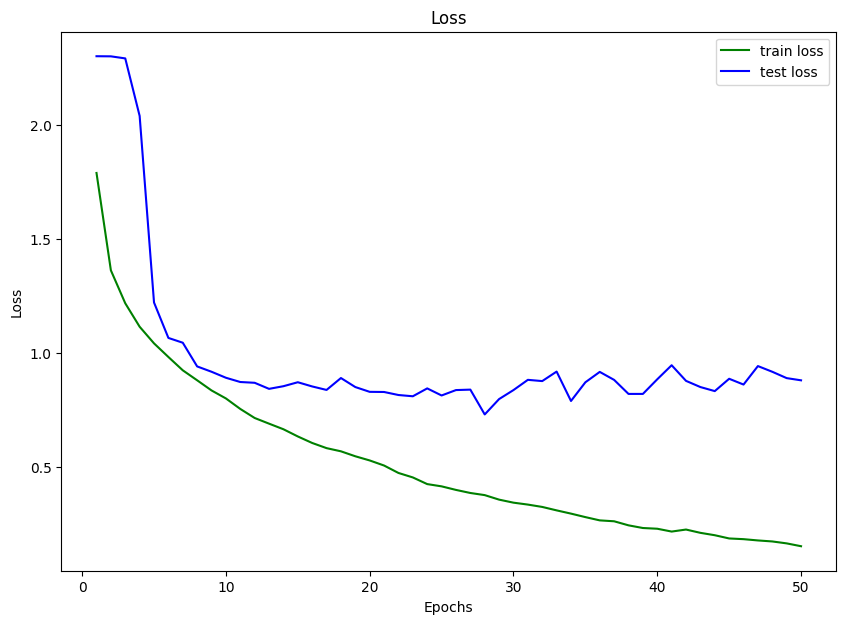

In [28]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend()

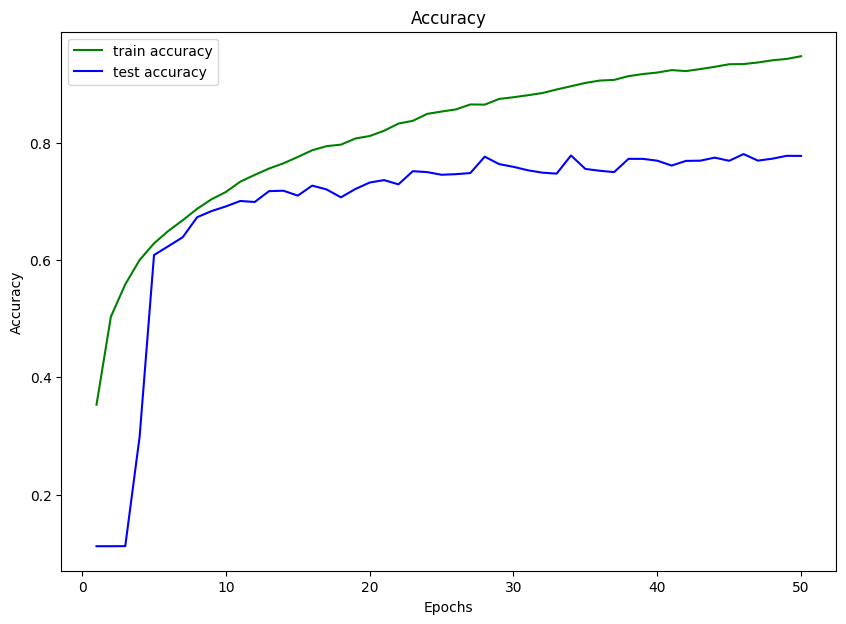

In [29]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~89% accuracy.

In [30]:
model.load_state_dict(torch.load('xception-cifar10-model.pt'))

test_loss, test_acc, top3_test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Top3 test Acc: {top3_test_acc*100:.2f}%')
torch.cuda.empty_cache()

Test Loss: 0.731 | Test Acc: 76.71% | Top3 test Acc: 94.91%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all the predictions.

In [31]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return (images, labels, probs)

In [32]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [33]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [34]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

The two classes our model seems to get mixed up the most is cat and dog.

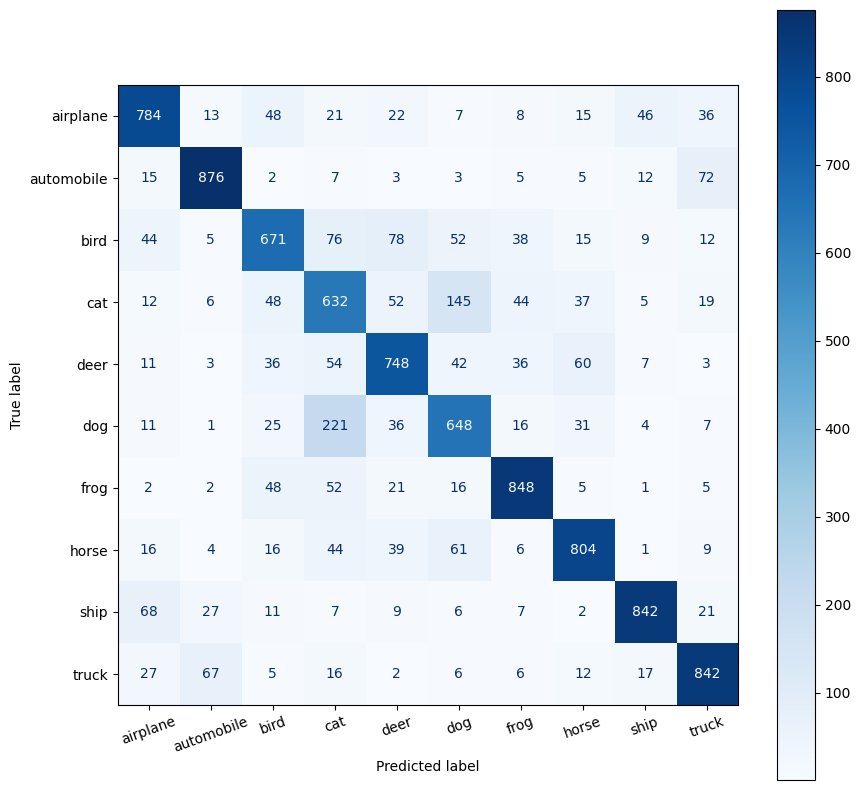

In [35]:
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [36]:
corrects = torch.eq(labels, pred_labels)

In [37]:
incorrect_examples = []

for (image, label, prob, correct) in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [38]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

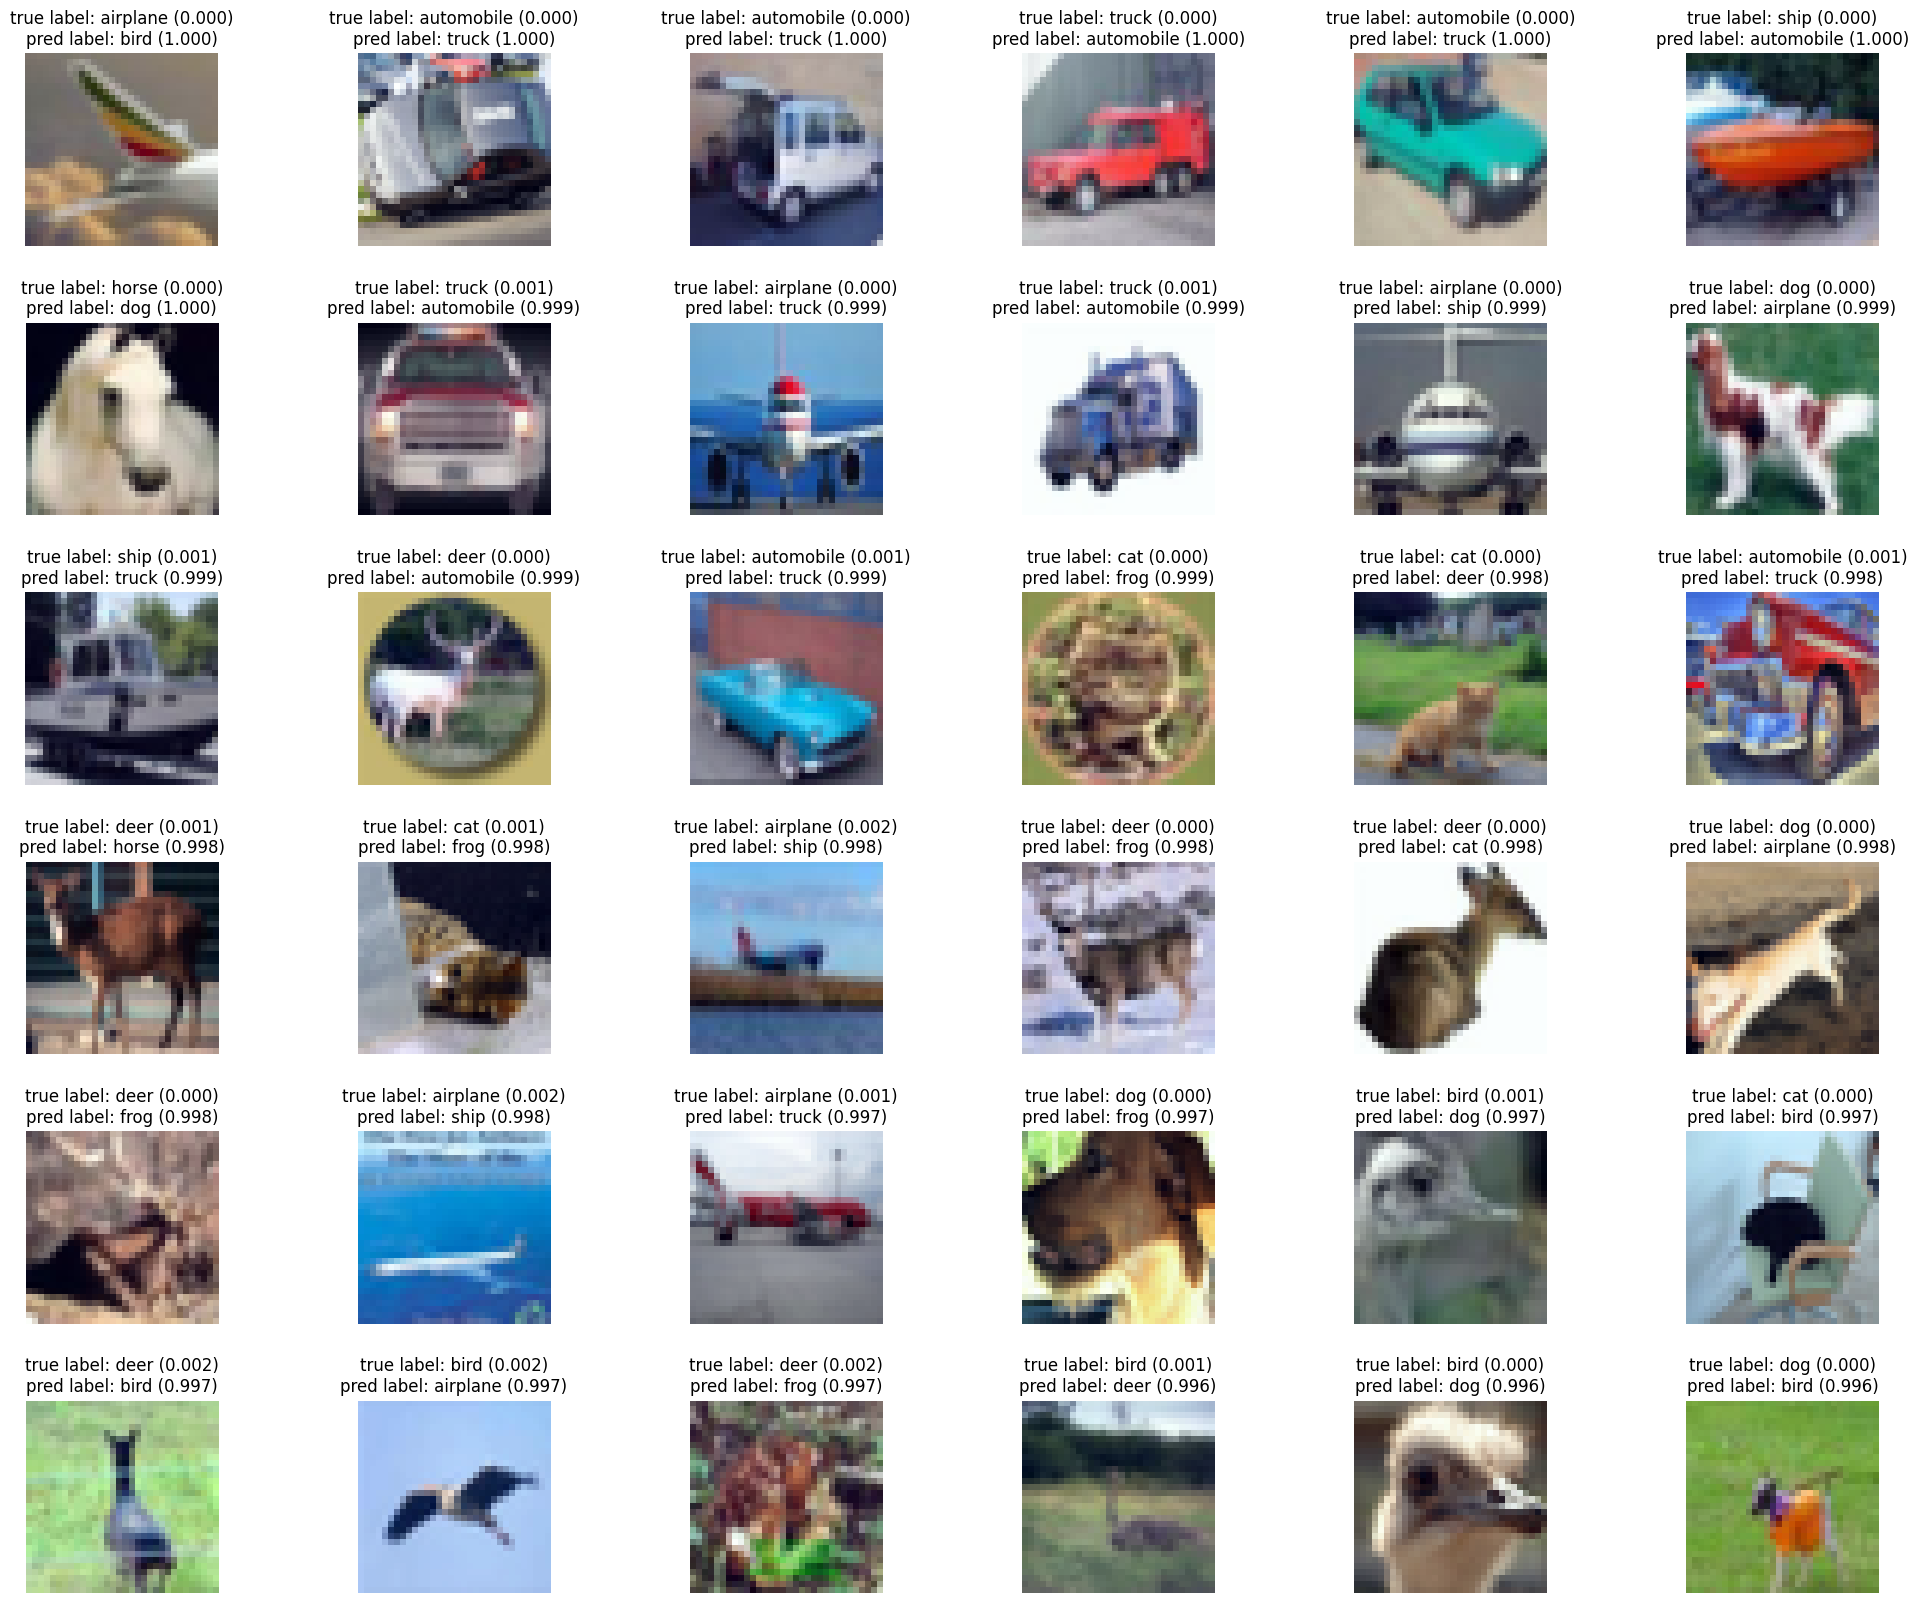

In [39]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [40]:
def get_representations(model, iterator, device):
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return (outputs, intermediates, labels)

In [41]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

We can then perform PCA on them both and plot them.

In [42]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [43]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

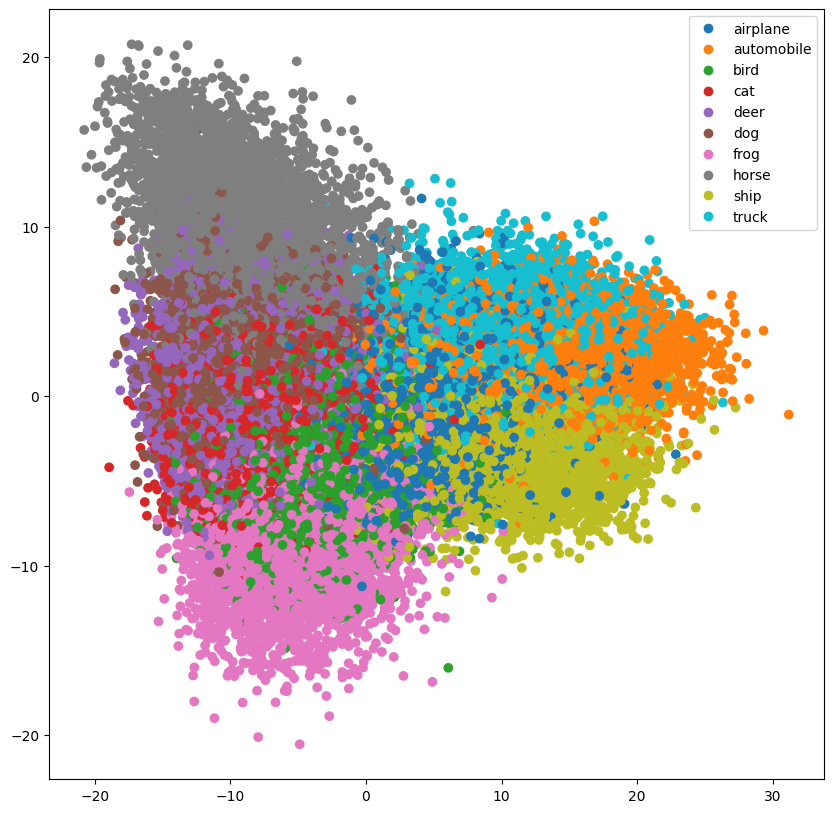

In [44]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

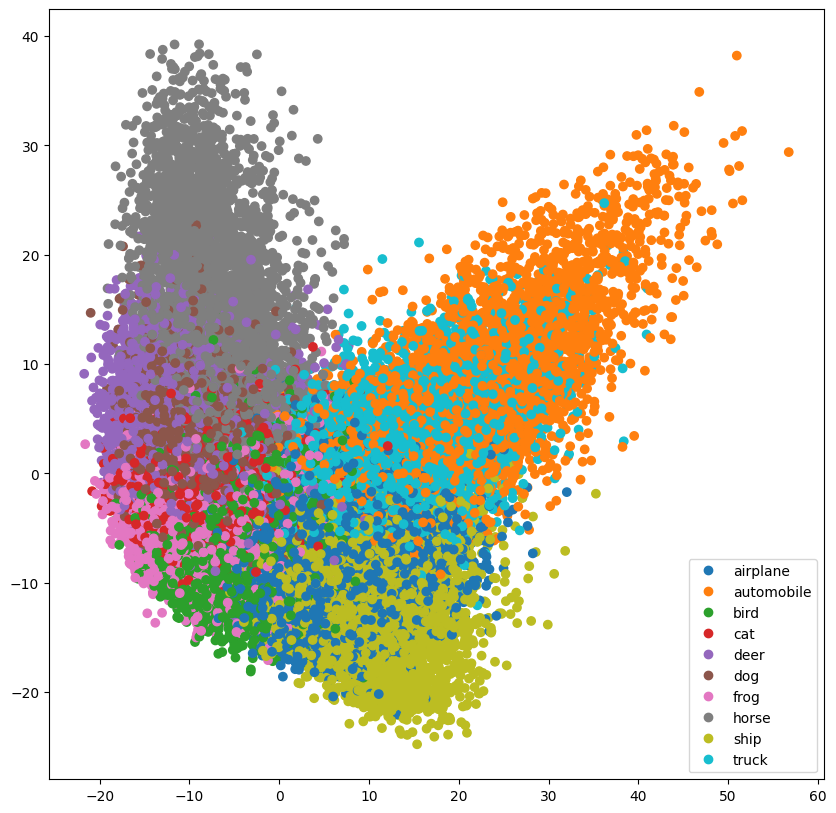

In [45]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [46]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

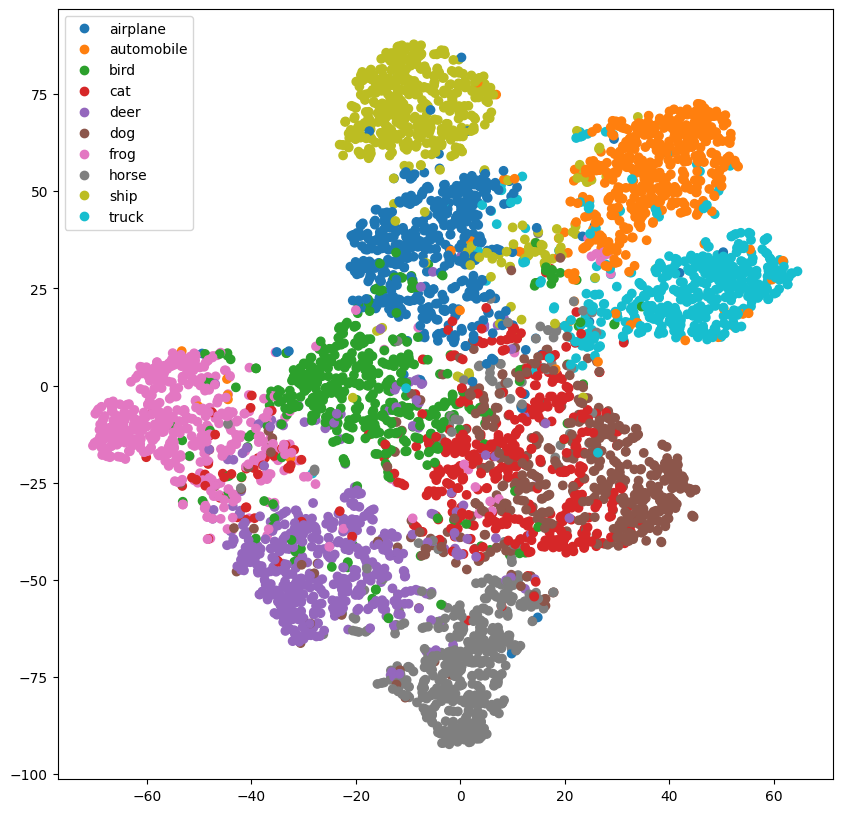

In [47]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

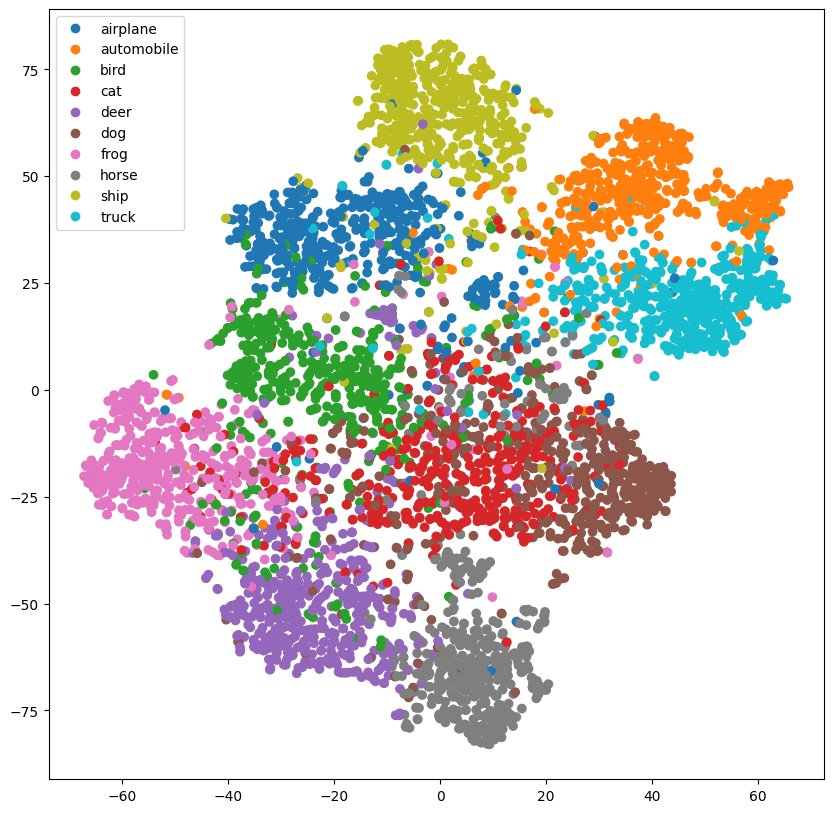

In [48]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [49]:
def imagine_image(model, classes, image, device, n_iterations=10_000):
    model.eval()

    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():
        for _ in trange(n_iterations):
            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, label], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [50]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [51]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


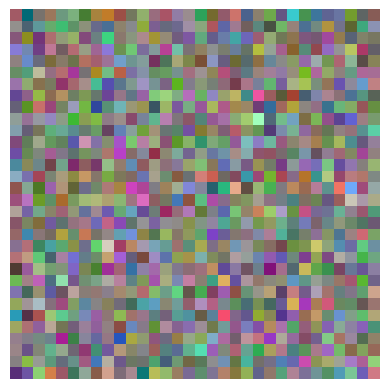

In [52]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [53]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

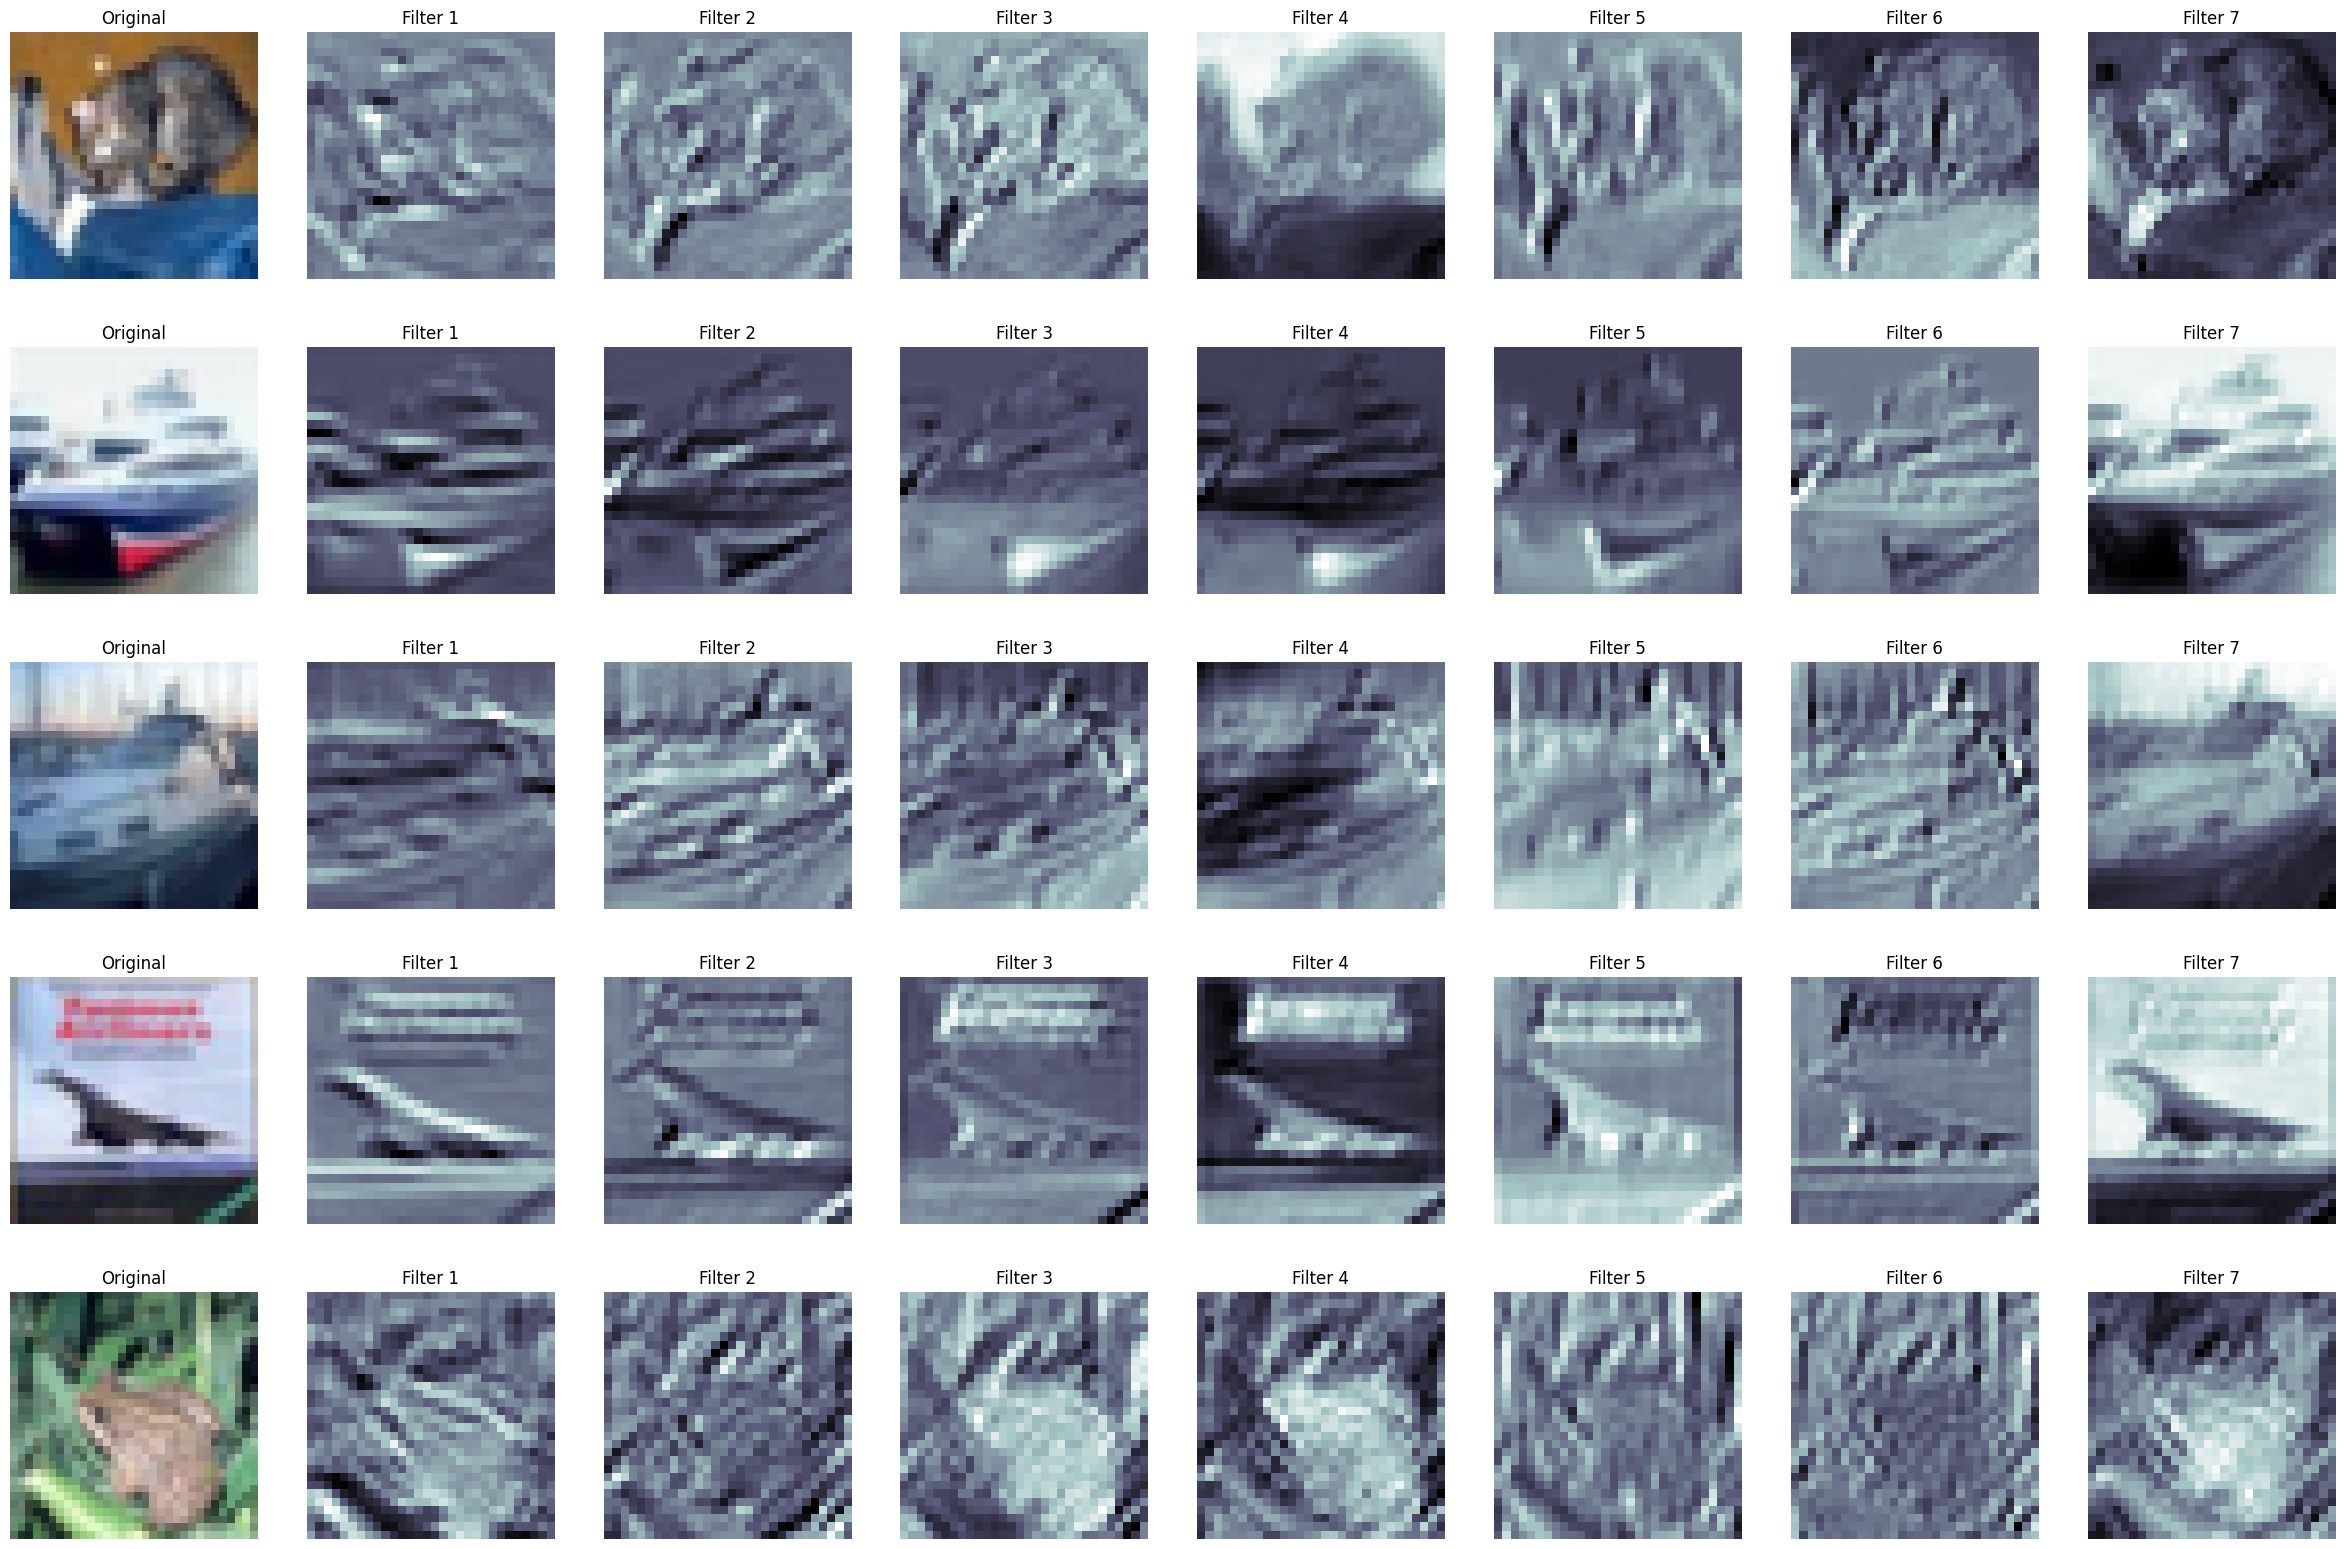

In [54]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
#filters = model.features[0].weight.data
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [55]:
def plot_filters(filters, normalize=True):
    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):
        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Again, nothing really interpretable here, sadly.

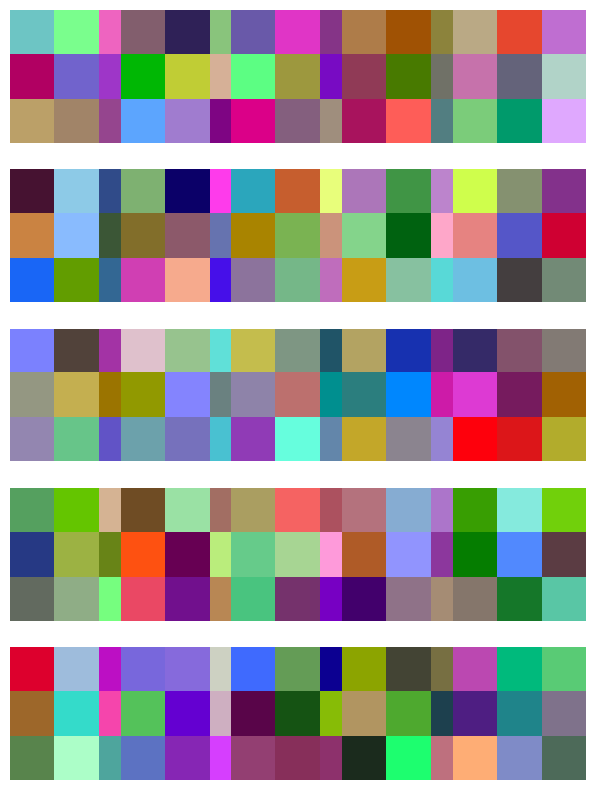

In [56]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (GooLeNet)
- custom weight initialization
- how to use the learning rate finder
- training a model to achieve >85% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake images
- viewing the learned weights of our model
- loading a pre-trained model

## Free GPU memory

In [ ]:
import os
 
pid = os.getpid()
!kill -9 $pid

# End